In [40]:
import numpy as np 
import pandas as pd 
import os
from matplotlib import pyplot as plt
import torch
import cv2
from PIL import Image

In [2]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\kgty\appdata\local\temp\pip-req-build-wl9ny2wo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36830 sha256=0bf4af6dff9743e9cf5fb7c27b3770f8fd923ef0ad688ffe7e359b72cf09abea
  Stored in directory: C:\Users\kgty\AppData\Local\Temp\pip-ephem-wheel-cache-cnnot2q9\wheels\10\cf\59\9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\kgty\AppData\Local\Temp\pip-req-build-wl9ny2wo'


In [3]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.5)))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [12]:
!curl -L -o sam_vit_h_4b8939.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 2445M    0  539k    0     0   325k      0  2:08:12  0:00:01  2:08:11  325k
  0 2445M    0 14.7M    0     0  5669k      0  0:07:21  0:00:02  0:07:19 5670k
  1 2445M    1 38.5M    0     0  10.4M      0  0:03:54  0:00:03  0:03:51 10.4M
  1 2445M    1 41.8M    0     0  8856k      0  0:04:42  0:00:04  0:04:38 8856k
  1 2445M    1 47.7M    0     0  8437k      0  0:04:56  0:00:05  0:04:51 9831k
  2 2445M    2 54.2M    0     0  8337k      0  0:05:00  0:00:06  0:04:54 10.7M
  2 2445M    2 63.0M    0     0  8433k      0  0:04:56  0:00:07  0:04:49 9904k
  3 2445M    3 80.7M    0     0  9550k      0  0:04:22  0:00:08  0:04:14 8720k
  4 2445M    4  115M    0     0  11.9M      0  0:03

In [34]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [17]:
from segment_anything import sam_model_registry, SamPredictor

predictor = SamPredictor(sam)

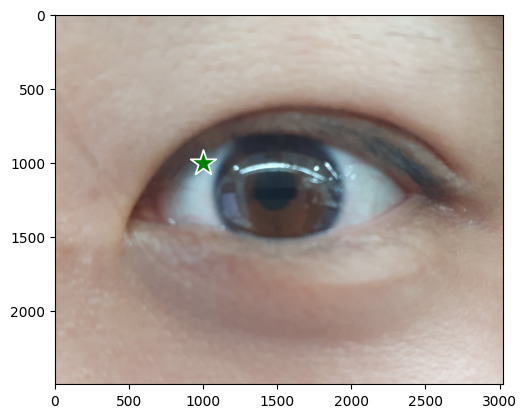

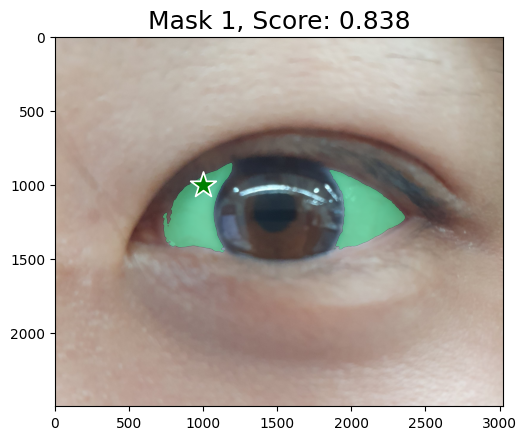

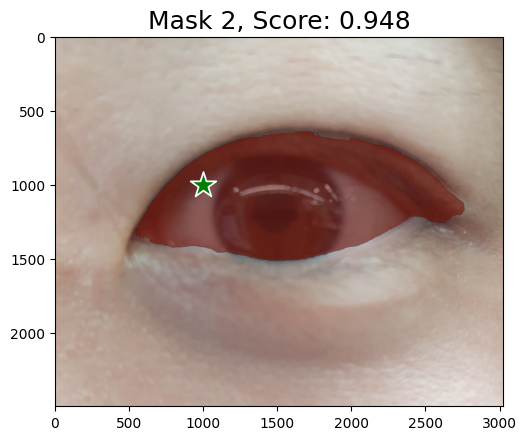

In [86]:
image_path = './minju_eye.jpg'
image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
predictor.set_image(image_array)

input_point = np.array([[1000, 1000]])
input_label = np.array([1])

plt.imshow(image_array)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  



masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
#     plt.figure(figsize=(10,10))
    plt.imshow(image_array)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.show()  
    if i == 1:
        break


In [87]:
def show_mask(mask, ax, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    save_binary_mask(mask_image, 'binary_mask.png')

In [92]:
binary_mask = (mask > 0.5).astype(np.uint8)
binary_mask = binary_mask * 5

In [93]:
image = Image.fromarray(binary_mask * 255)  # PIL은 0-255 범위를 사용
image.save('ttttttttttttt.png')

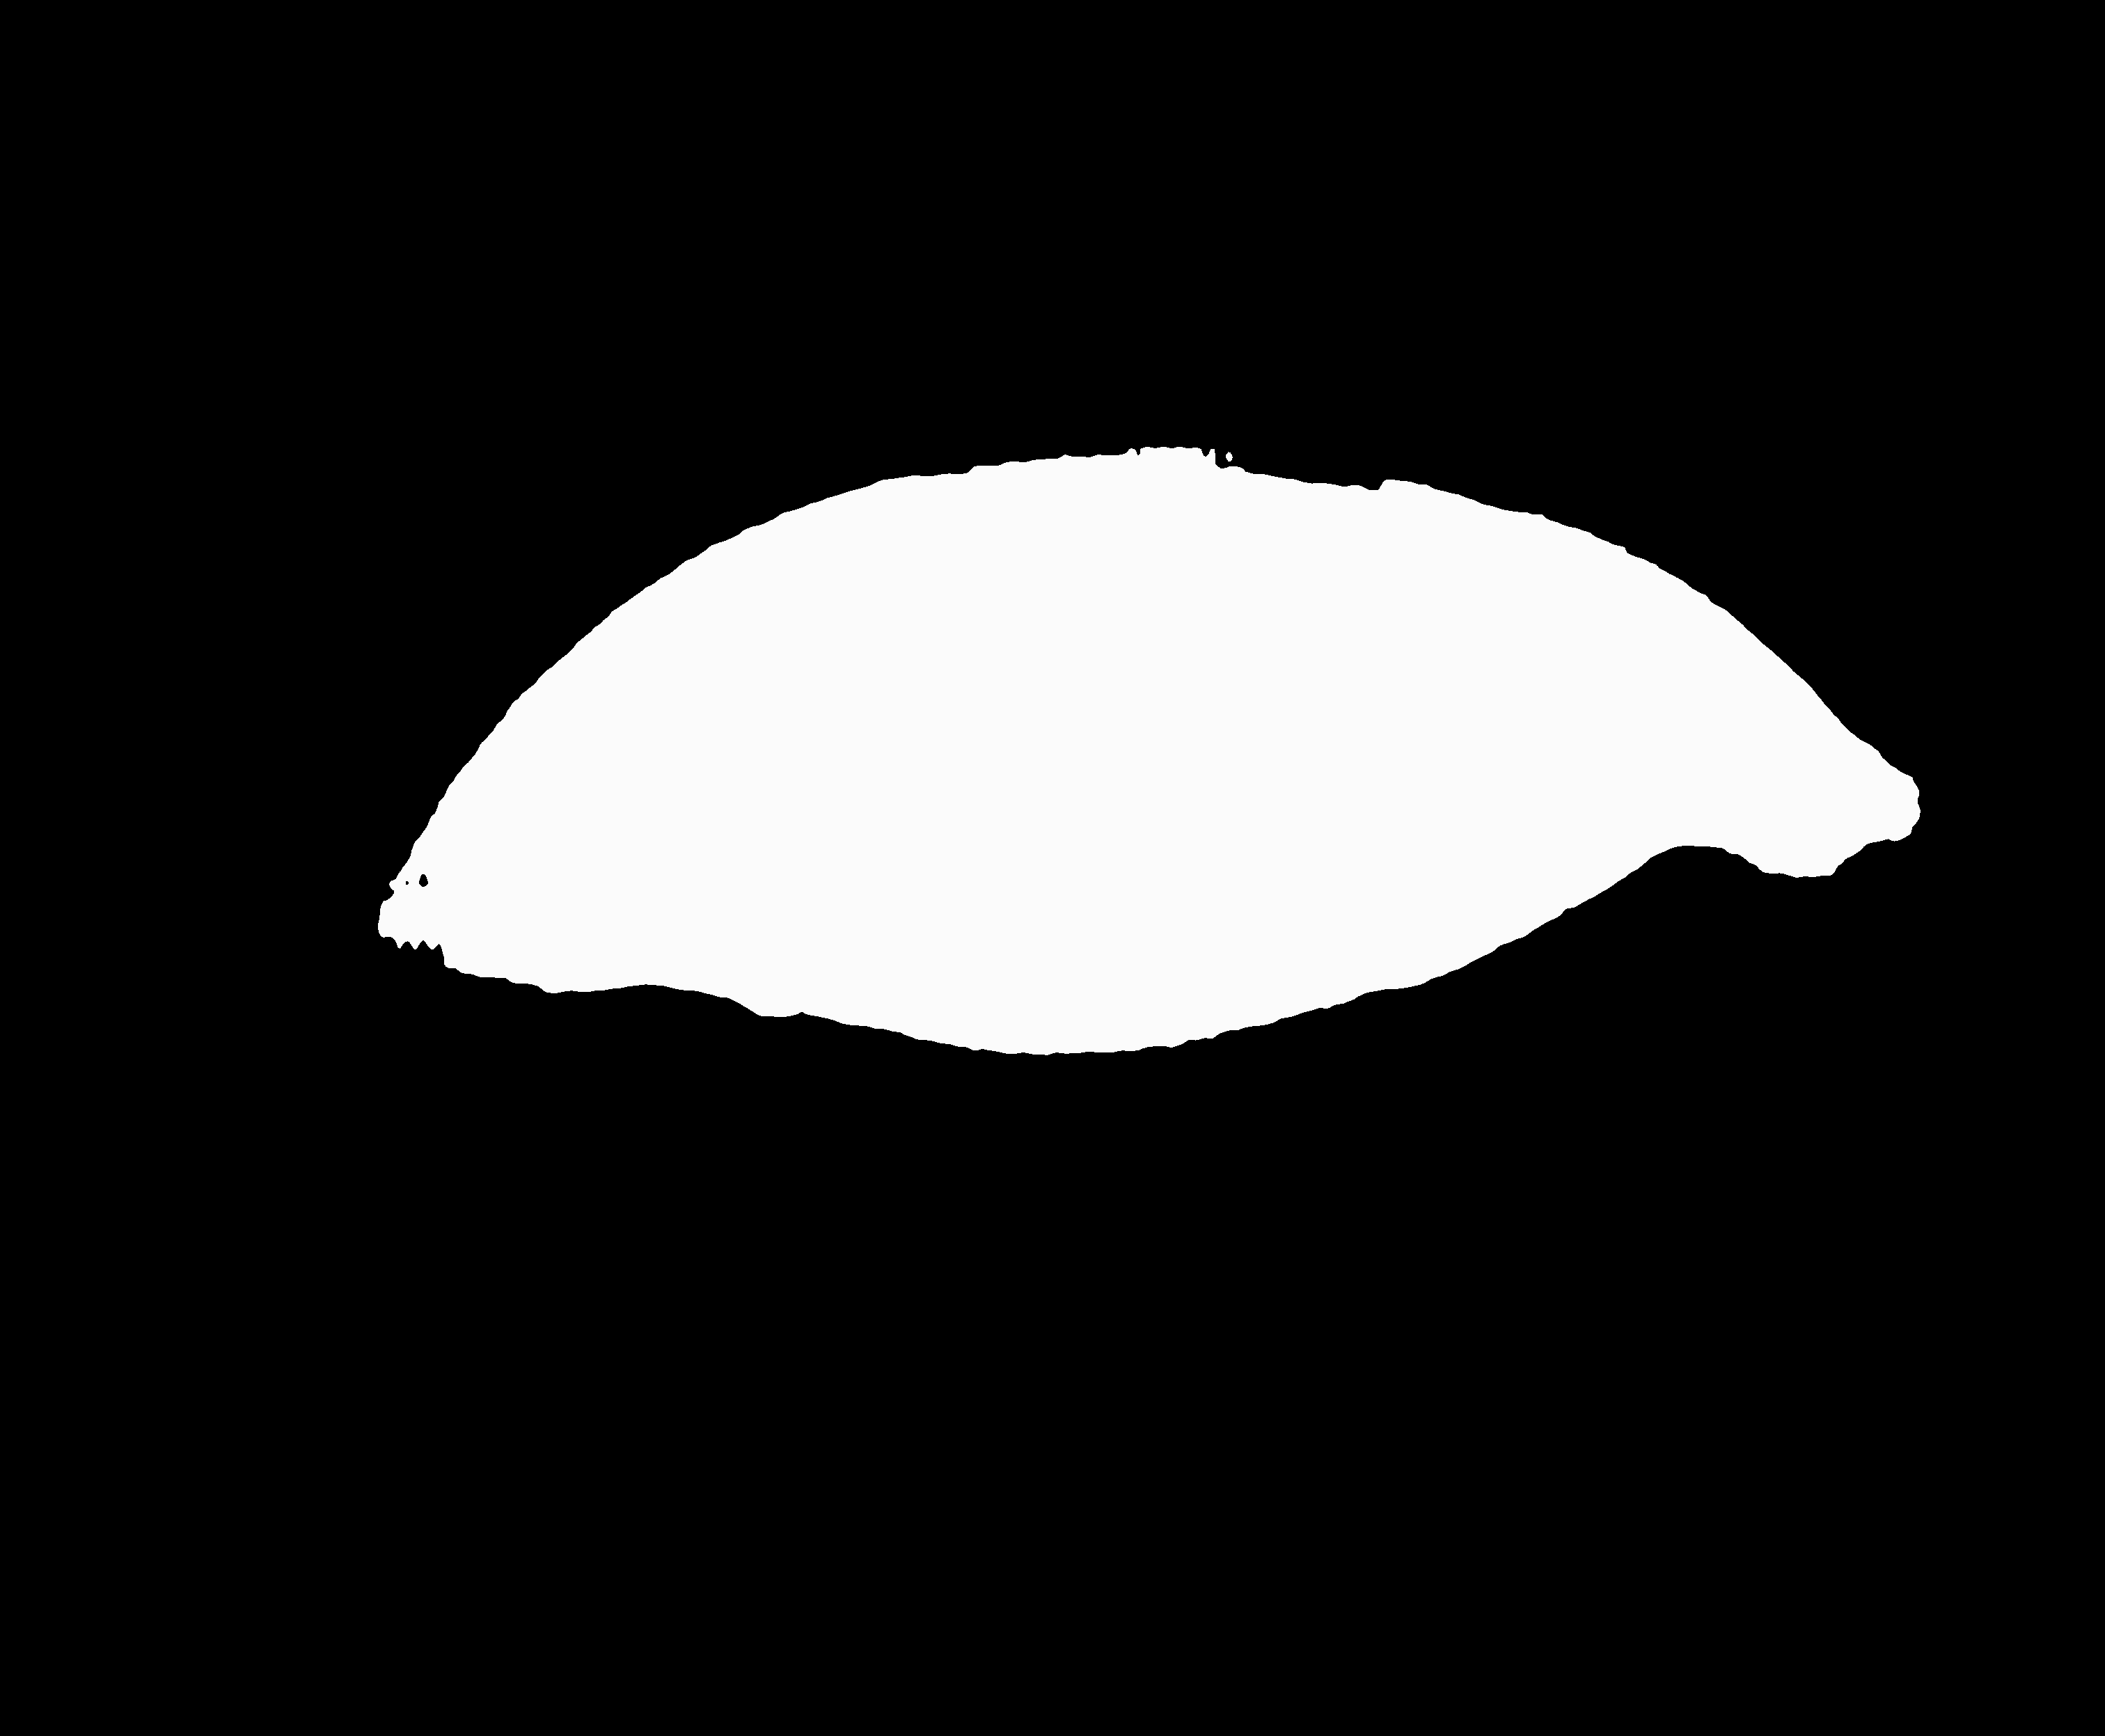

In [94]:
Image.open('ttttttttttttt.png')